## Notebook 4.1: Training GPT Model from Scratch 🛠️
## Introduction 🚀

In this notebook, we move beyond model construction and dive into the critical next phase—training our custom GPT model. Now that we've successfully built the GPT architecture in the previous notebook, it’s time to bring it to life by implementing a basic training loop and putting it to work on our prepared dataset. We’ll focus on the essential components that drive model training, from data preprocessing to optimization, and gradually watch our GPT model learn from scratch.

<div align="center">

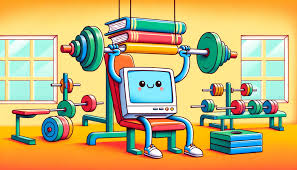
</div>

### What’s Inside?

1. **Setting Up the Data Pipeline**: We'll begin by loading and preprocessing the dataset, ensuring that it’s in the correct format to feed into the model for training.

2. **Building the Training Loop**: Next, we’ll implement a basic training loop from scratch, including forward passes, loss computation, backpropagation, and weight updates using gradient descent.

3. **Evaluating Training Progress**: We’ll monitor training performance by computing metrics like loss and accuracy at regular intervals, providing us with insights into how well the model is learning over time.

4. **Saving Model Checkpoints**: To preserve our progress, we’ll implement a system to save model checkpoints periodically, allowing us to resume training or perform inference at any stage.

By the end of this notebook, you'll have a functional training loop capable of training your GPT model from scratch on your custom dataset. This is a crucial step in the journey, laying the groundwork for future improvements and fine-tuning.

**Sneak Peek**: In the following notebook, we’ll explore more advanced training techniques like multi-GPU training, mixed precision, learning rate schedulers, gradient accumulation, and more to further optimize the performance of our model.

Let’s get started with the basics! 🏁


In [4]:
# importing all we need for this notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader , Dataset
import tiktoken 


## 1- Setting Up the Data Pipeline 📂

In our first notebook, we took care of all the heavy lifting by loading the dataset, performing the necessary preprocessing steps, and saving the data in a `.bin` format, ready for training. Now, it's time to retrieve those prepared datasets and convert them into data loaders, ensuring that our data flows efficiently into the training loop.

### What’s Inside?

1. **Loading the Preprocessed Dataset**: We’ll begin by loading the `.bin` files that contain our tokenized and preprocessed data. This ensures that we start training directly with the formatted dataset, avoiding any redundant preprocessing steps.
   
2. **Creating Data Loaders**: Once the data is loaded, we’ll set up PyTorch `DataLoader` objects. These will handle batching, shuffling, and sampling the data during training, providing a streamlined process to feed data into our model.

3. **Ensuring Efficient Memory Usage**: We’ll take special care to ensure that our data pipeline is optimized for performance, focusing on memory efficiency and proper batch handling to avoid bottlenecks during training.

By the end of this step, we’ll have a fully functional data pipeline, with our dataset neatly loaded into `DataLoader`s, ready to fuel the training process. This ensures our model receives batches of data in the correct format, while efficiently managing the flow of data between disk and memory.

Let’s retrieve those datasets and get everything ready for training! ⚙️


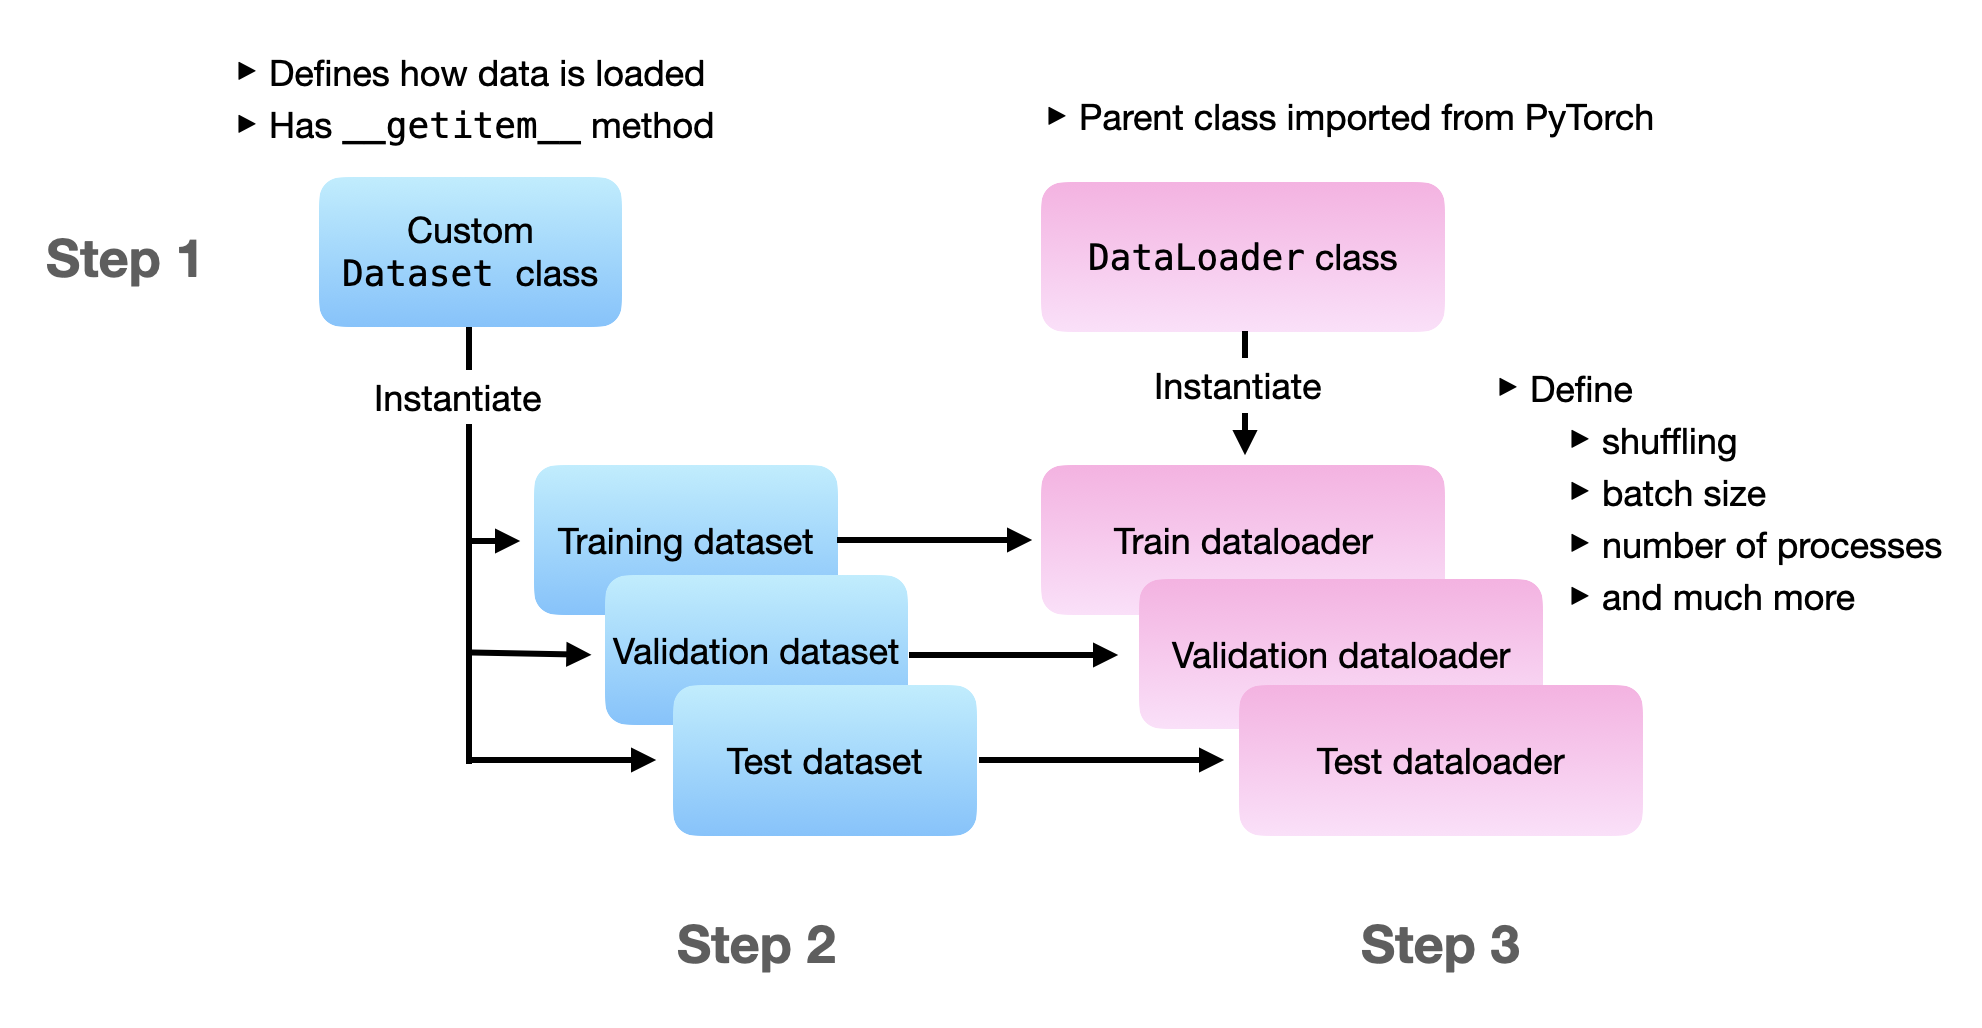

In [5]:
# this is the  class we desifned in the first notebook
class GPT2Dataset(Dataset):
    def __init__(self, file_path, max_length, stride):
        # Load the binary file into a NumPy array
        self.data = np.fromfile(file_path, dtype=np.int32)
        self.max_length = max_length  # Maximum length of input sequence
        self.stride = stride  # Stride defines how much to slide the window

    def __len__(self):
        # Return the total number of samples based on data length, max_length, and stride
        return (len(self.data) - self.max_length) // self.stride

    def __getitem__(self, idx):
        # Calculate the starting index for the input sequence based on the stride
        start_idx = idx * self.stride
        
        # Extract the input sequence from the data
        input_seq = self.data[start_idx: start_idx + self.max_length]
        
        # Extract the output sequence (next tokens) by shifting the input sequence by 1
        output_seq = self.data[start_idx + 1: start_idx + self.max_length + 1]
        
        # Convert the input and output sequences to PyTorch tensors
        input_seq = torch.tensor(input_seq, dtype=torch.long)
        output_seq = torch.tensor(output_seq, dtype=torch.long)
        
        return input_seq, output_seq



In [6]:

# Adjusted configuration for CPU-friendly training.
# These changes are aimed at reducing the model size and computational cost
# to make training manageable on a CPU.
GPT_CONFIG_CPU_FRIENDLY = {
    "vocab_size": 50257,        # The total size of the vocabulary (remains unchanged to match tokenizer output)
    "context_length": 256,      # Reduced sequence length from 512 to 256 for smaller memory footprint
    "emb_dim" : 512,            # Reduced embedding dimension from 768 to 512 to lower computational cost
    "n_heads" : 8,              # Reduced the number of attention heads from 12 to 8 to reduce computation per layer
    "n_layers" : 6,             # Reduced the number of layers from 12 to 6 to make the model lighter
    "drop_rate" : 0.1,          # Retained dropout at 10% to regularize training without making it too unstable
    "qkv_bias" : False,         # Keeps the bias configuration for the query, key, and value projections
}

In [7]:
# File paths for the preprocessed data
train_path = 'data/train_ids.bin'  # Path to the training dataset
val_path = 'data/val_ids.bin'  # Path to the validation dataset
test_path = 'data/test_ids.bin'  # Path to the test dataset

# Define parameters for DataLoader
batch_size = 2 # Number of samples in each batch. A lower batch size helps fit the data into memory when working with large models.
num_workers = 0  # Disable multiprocessing for data loading, which is recommended when using a CPU only.
pin_memory = False  # This option is useful for GPU training, so we disable it for CPU-only training.

# Create dataset instances using the GPT2Dataset class we defined earlier.
# The dataset class takes care of loading the data from the .bin file and providing input-output sequences.
train_dataset = GPT2Dataset(file_path=train_path,
                            max_length=GPT_CONFIG_CPU_FRIENDLY["context_length"],
                            stride=GPT_CONFIG_CPU_FRIENDLY["context_length"])

val_dataset = GPT2Dataset(file_path=val_path,
                           max_length=GPT_CONFIG_CPU_FRIENDLY["context_length"],
                           stride=GPT_CONFIG_CPU_FRIENDLY["context_length"])

test_dataset = GPT2Dataset(file_path=test_path,
                           max_length=GPT_CONFIG_CPU_FRIENDLY["context_length"],
                        stride=GPT_CONFIG_CPU_FRIENDLY["context_length"])

# Create DataLoaders for each dataset
# DataLoader handles batching, shuffling, and loading data efficiently during training and validation.
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,  # Specifies the number of samples to load per batch.
    shuffle=True,  # Shuffle the training data to ensure randomness and help generalization.
    num_workers=num_workers  # Number of worker threads for loading data; we set it to 0 for single-threaded loading.
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size,  # Batch size for validation data.
    shuffle=False,  # No need to shuffle validation data since it does not impact the validation process.
    num_workers=num_workers  # Single-threaded data loading.
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size,  # Batch size for test data.
    shuffle=False,  # No need to shuffle test data.
    num_workers=num_workers  # Single-threaded data loading.
)

# Check if the DataLoader works correctly by fetching one batch from the training set
# This loop fetches a single batch (of input-output sequences) and prints the shapes for verification.
for batch in train_loader:
    input_seq, output_seq = batch  # Extract input and output sequences from the batch
    print("Input sequence shape:", input_seq.shape)  # Display the shape of the input sequence
    print("Output sequence shape:", output_seq.shape)  # Display the shape of the output sequence (next tokens)
    break  # Break after one iteration to check if data loading works as expected


Input sequence shape: torch.Size([2, 256])
Output sequence shape: torch.Size([2, 256])


## Adjusting Model Configuration for CPU-Only Training ⚙️

Since we're currently training on a CPU, it's crucial to make the model more lightweight to ensure the training process is manageable and efficient. The original configuration is based on the GPT-124M model, which, while small in comparison to larger GPT models, can still be computationally heavy for CPU-only environments. 

To strike a balance between model complexity and training feasibility, we made the following adjustments:

### Key Changes:
1. **Context Length (`context_length`)**:
   - **Original: 512** → **New: 256**
   - The context length determines the number of tokens the model processes at once. Reducing this to 256 (or even 128) will cut down memory consumption significantly, speeding up the training process without sacrificing too much context for learning.

2. **Embedding Dimension (`emb_dim`)**:
   - **Original: 768** → **New: 512**
   - A smaller embedding dimension means the model has fewer parameters, leading to faster training and less memory usage. This adjustment reduces the model's capacity slightly but makes training feasible on CPU.

3. **Number of Transformer Layers (`n_layer`)**:
   - **Original: 12** → **New: 6**
   - Reducing the number of layers cuts down the model’s depth. This makes each forward and backward pass faster while still retaining enough complexity to learn effectively from the data.

4. **Number of Attention Heads (`n_head`)**:
   - **Original: 12** → **New: 8**
   - The number of attention heads controls how many parallel attention mechanisms are used in each layer. Reducing it to 8 lowers computational load without sacrificing the benefits of multi-head attention.

5. **Vocabulary Size (`vocab_size`)**:
   - This remains unchanged at **50257**, as it matches the tokenization setup of GPT models. Reducing it could complicate tokenization and potentially degrade the quality of text generation.

6. **Dropout (`dropout`)**:
   - We keep dropout at **0.1**, as it’s a regularization mechanism that helps prevent overfitting during training, especially with smaller datasets.

### Why These Changes?
These modifications make the model much more efficient to train on a CPU by reducing memory usage and speeding up computation. Although we sacrifice some of the model’s capacity and sequence length, the trade-off is worth it for the faster training time and lower resource consumption. The model should still be able to learn effectively on your dataset, making it a practical choice while you work without GPU access.

As we scale the project or move to more powerful hardware, we can gradually increase the model size again.


In [8]:
import sys

# Add the model's path to Python's system path to make sure the module is found.
# This allows us to import the custom GPTModel class from the 'models' directory.
sys.path.append(r'C:\Users\user\Documents\SILVA.AI\MyLLM\models')

# Import the custom GPT model from the previously built module.
# The 'GPTModel' class was built in an earlier notebook, so we're leveraging that here.
from GPT.GPT import GPTModel  

# Initialize the GPT model with the adjusted configuration designed for CPU-based training.
# This will create a smaller, more efficient version of the model based on the settings above.
model = GPTModel(GPT_CONFIG_CPU_FRIENDLY)

# Print out the model architecture to verify that it has been initialized correctly
# and to check the configuration matches the CPU-friendly adjustments.
print(model)


GPTModel(
  (tok_emb): Embedding(50257, 512)
  (pos_emb): Embedding(256, 512)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=512, out_features=512, bias=False)
        (W_key): Linear(in_features=512, out_features=512, bias=False)
        (W_value): Linear(in_features=512, out_features=512, bias=False)
        (out_proj): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): GELU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 2- Building the Training Loop
## Basic Components of the Training Loop 🔄

In this section, we will outline the fundamental components of a training loop that will serve as the backbone for our model training process. Understanding these components is crucial before we explore more advanced and customized training techniques.

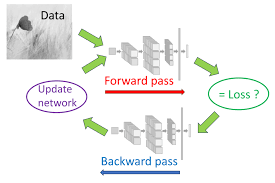 

### 1. Data Loading

The first step involves loading our dataset using DataLoaders. This allows us to efficiently iterate over the training data in batches, which helps manage memory usage and speeds up the training process. In our case, we have:

- **Training DataLoader**: Supplies batches of training samples for the model.
- **Validation DataLoader**: Supplies batches of validation samples to assess the model's performance during training.

### 2. Forward Pass

In the forward pass, we pass a batch of input sequences through the model to obtain predictions (outputs). This involves:

- **Input Preparation**: Moving the input sequences to the appropriate device (CPU or GPU).
- **Model Invocation**: Calling the model with the input data to generate predictions.

### 3. Loss Calculation

Once we have the model's predictions, we need to evaluate how well the model performed by calculating the loss. The loss function measures the difference between the predicted outputs and the actual target labels. Common loss functions include:

- **Cross-Entropy Loss**: Often used for classification tasks, particularly in natural language processing tasks.

### 4. Backward Pass

The backward pass computes the gradients of the loss with respect to the model's parameters. This step is crucial for updating the model during training. It involves:

- **Gradient Calculation**: Using the `.backward()` method to compute the gradients based on the loss.
- **Optimizer Step**: Updating the model parameters using an optimization algorithm (e.g., Adam, SGD) to minimize the loss.

### 5. Monitoring

Throughout the training loop, it’s important to monitor the model's performance by tracking metrics such as:

- **Loss Value**: Helps us understand how well the model is learning over time.
- **Validation Accuracy**: Evaluates the model's performance on unseen data.

By understanding these basic components, we lay the groundwork for implementing more advanced training techniques, such as gradient accumulation, learning rate scheduling, and multi-GPU training, which we will explore in the subsequent sections.


In [9]:
# Define a function to calculate the average loss over all batches from the data loader

# Define a function to calculate the loss for a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    
    # Move input and target batches to the appropriate device (CPU/GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Forward pass: Get model predictions (logits) for the input batch
    logits = model(input_batch)

    # Calculate the cross-entropy loss by flattening logits and targets
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    
    return loss  # Return the computed loss


# Define a function to calculate the average loss over a specified number of batches from the data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    
    total_loss = 0.  # Initialize total loss to zero

    # Check if the data loader is empty and return NaN if it is
    if len(data_loader) == 0:
        return float("nan")
    
    # Determine the number of batches to process
    elif num_batches is None:
        num_batches = len(data_loader)  # Use all batches
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    # Iterate through the batches in the data loader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:  # Process only the specified number of batches
            # Calculate loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # Accumulate the loss
        else:
            break  # Exit if the specified number of batches has been processed

    # Return the average loss across the specified number of batches
    return total_loss / num_batches

# Explanation:
# 1. The `calc_loss_batch` function computes the loss for a single batch of input and target sequences.
# 2. It uses cross-entropy loss, which is standard for classification tasks, particularly in language models.
# 3. The `calc_loss_loader` function computes the average loss over multiple batches provided by the data loader.
# 4. It allows for flexible evaluation by specifying the number of batches to process, or defaults to all available batches.
# 5. If the data loader is empty, it returns NaN, ensuring robust error handling.
# 6. The functions leverage PyTorch's capabilities to move data to the appropriate device

## Overfitting on a single batch
**Best Practice:** Before moving on to build our custom training loop, it's essential to test the model with a single batch of data. This initial step allows us to verify that the loss decreases significantly—ideally approaching zero—indicating that everything is functioning as expected. By doing this, we can ensure a smooth training process without relying on the more expensive resources like GPUs until we're confident in our implementation.


In [10]:
def trainerV0(model, train_loader, optimizer, device, num_epochs):
    # Initialize a list to store the training losses for each epoch
    train_losses = []  
    
    # Initialize the global step counter, which keeps track of the number of training steps
    global_step = 0  

    # Get a single batch from the train_loader
    # This is done by getting the first element from the iterator of the train_loader
    input_batch, target_batch = next(iter(train_loader))
    
    # Move input and target batches to the specified device (CPU or GPU)
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    # Check if the input batch exceeds the context length defined in the model configuration
    if input_batch.size(1) > model.cfg["context_length"]:
        # If it does, slice the input and target batches to fit within the context length
        input_batch = input_batch[:, :model.cfg["context_length"]]
        target_batch = target_batch[:, :model.cfg["context_length"]]

    # Loop over the number of epochs specified for training
    for epoch in range(num_epochs):
        # Set the model to training mode to enable dropout and batch normalization if used
        model.train()  

        # Reset the gradients for the optimizer before the training iteration
        optimizer.zero_grad()  

        # Calculate the loss on the single batch using the calc_loss_batch function
        loss = calc_loss_batch(input_batch, target_batch, model, device)

        # Backpropagate the loss to compute gradients for the model parameters
        loss.backward()  

        # Update the model weights based on the computed gradients
        optimizer.step()  

        # Increment the global step counter for tracking progress
        global_step += 1  

        # Append the current loss to the list of training losses
        train_losses.append(loss.item())  

        # Print the current epoch number, global step, and training loss for monitoring progress
        print(f"Epoch {epoch + 1}, Step {global_step}, Train Loss: {loss.item():.4f}")

    # Return the list of training losses after completing all epochs
    return train_losses  


In [11]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create a DataLoader with a batch size of 1 for overfitting on a single batch
train_loader_overfit = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Clear any cached memory on the GPU to prevent out-of-memory errors
torch.cuda.empty_cache()

# Initialize the GPT model using a CPU-friendly configuration
gpt = GPTModel(GPT_CONFIG_CPU_FRIENDLY)

# Define the optimizer for training, using Adam with a learning rate of 0.001
optimizer = torch.optim.Adam(gpt.parameters(), lr=0.001)

# Get a single batch from the DataLoader to train on
single_batch = next(iter(train_loader_overfit))
input_batch, target_batch = single_batch

# Move the input and target batches to the appropriate device (GPU/CPU)
input_batch = input_batch.to(device)
target_batch = target_batch.to(device)

# Move the model to the specified device
gpt.to(device)

# Call the training function to train the model on the single batch
train_losses = trainerV0(
    model=gpt,
    train_loader=[(input_batch, target_batch)],  # Wrap the single batch in a list for the trainer
    optimizer=optimizer,
    device=device,
    num_epochs=50,  # Specify the number of epochs for training
)

# Optionally, print the training losses after the training loop completes
print("Training losses for single batch:", train_losses)

# the output of the training function is a list of training losses and its must be nedar to zero

Epoch 1, Step 1, Train Loss: 10.9471
Epoch 2, Step 2, Train Loss: 7.6724
Epoch 3, Step 3, Train Loss: 5.9353
Epoch 4, Step 4, Train Loss: 4.3841
Epoch 5, Step 5, Train Loss: 3.1226
Epoch 6, Step 6, Train Loss: 2.2905
Epoch 7, Step 7, Train Loss: 1.7185
Epoch 8, Step 8, Train Loss: 0.9917
Epoch 9, Step 9, Train Loss: 0.6636
Epoch 10, Step 10, Train Loss: 0.3713
Epoch 11, Step 11, Train Loss: 0.2077
Epoch 12, Step 12, Train Loss: 0.1172
Epoch 13, Step 13, Train Loss: 0.0732
Epoch 14, Step 14, Train Loss: 0.0509
Epoch 15, Step 15, Train Loss: 0.0348
Epoch 16, Step 16, Train Loss: 0.0248
Epoch 17, Step 17, Train Loss: 0.0176
Epoch 18, Step 18, Train Loss: 0.0138
Epoch 19, Step 19, Train Loss: 0.0110
Epoch 20, Step 20, Train Loss: 0.0091
Epoch 21, Step 21, Train Loss: 0.0076
Epoch 22, Step 22, Train Loss: 0.0066
Epoch 23, Step 23, Train Loss: 0.0056
Epoch 24, Step 24, Train Loss: 0.0049
Epoch 25, Step 25, Train Loss: 0.0046
Epoch 26, Step 26, Train Loss: 0.0038
Epoch 27, Step 27, Train Loss

## LETS SEE THE RESULTS OF THE TRAINING

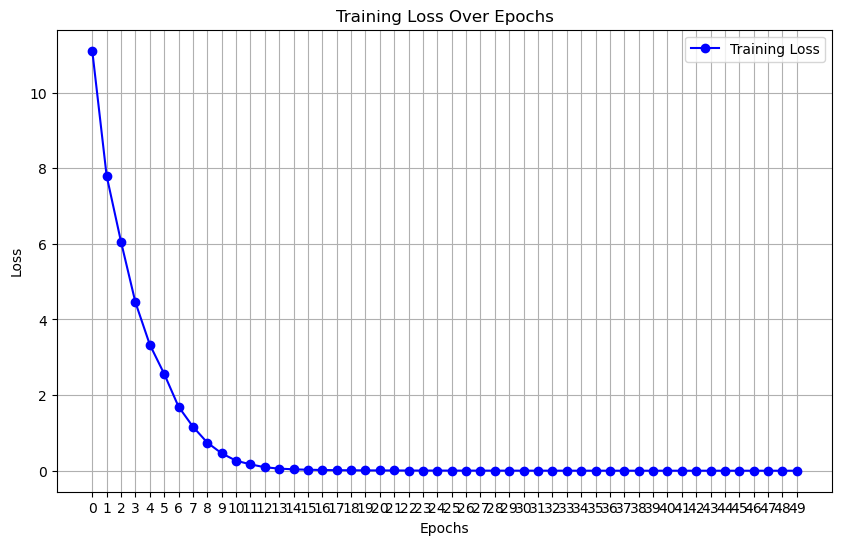

In [34]:

# Plotting the training losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue', marker='o')  # Plot with markers for clarity
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(len(train_losses)))  # Set x-ticks to be the epoch numbers
plt.grid()
plt.legend()
plt.show()


### Components of a Custom Training Loop

1. **Model Setup & Initialization**  
   The training process begins by setting the model to training mode, ensuring that specific behaviors (like dropout, if applicable) work correctly for training. The loop also initializes variables to track losses, steps, and other metrics.

2. **Processing Each Batch**  
   For each batch of data, the model's gradients are reset to avoid accumulation from previous iterations. The model processes the input data, computes the loss, and then backpropagates the loss to compute gradients. The optimizer uses these gradients to update the model's parameters, allowing it to improve over time.

3. **Tracking Progress**  
   As training proceeds, the number of processed data points or tokens is tracked, and a global step counter is updated to monitor how many batches have been processed. This helps in keeping track of the overall progress during training.

4. **Periodic Evaluation**  
   At regular intervals (e.g., after a certain number of steps), the model is evaluated on both the training and validation sets. This evaluation helps monitor the model's performance, providing insight into whether the model is improving and whether it's at risk of overfitting.

5. **Feedback Through Output Generation**  
   After each epoch, the model generates a sample output, such as a text or image, depending on the task. This feedback offers a direct look at how the model is learning, helping guide the training process and identify potential issues early on.

6. **Result Tracking**  
   Throughout the process, key metrics like training and validation losses are logged, and the number of processed data points is tracked. This data can be used to analyze the model's learning curve and make adjustments to the training strategy if needed.


So first lets code up the helper function for generating text through out the training process : 

In [12]:
# A helper function to generate text during the training process
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is a (B, T) array of indices representing the current context
    # B: batch size, T: current sequence length

    for _ in range(max_new_tokens):
        # Loop to generate tokens one at a time until the desired number is reached

        # Crop the current context if it exceeds the supported context size
        # For instance, if the model supports a maximum context size of 5 tokens,
        # but we provide a sequence of 10 tokens, we only use the last 5 tokens.
        idx_cond = idx[:, -context_size:]  # Use only the last context_size tokens

        # Get the model's predictions for the current context
        with torch.no_grad():  # Disable gradient calculation for efficiency during inference
            logits = model(idx_cond)  # Feed the context into the model to get predictions

        # Focus only on the last time step's logits
        # This reduces the logits shape from (batch, n_tokens, vocab_size) to (batch, vocab_size)
        logits = logits[:, -1, :]

        # Determine the index of the vocabulary entry with the highest logit value (greedy sampling)
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append the sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens + 1)

    return idx  # Return the final sequence of indices with the newly generated tokens

# A helper function to convert text to token IDs using the tokenizer
def text_to_tokens_ids(text, tokenizer):
    # Encode the input text into token IDs
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})  # Special tokens allowed
    return torch.tensor(encoded).unsqueeze(0)  # Convert to tensor and add batch dimension

# A helper function to decode token IDs back to text using the tokenizer
def token_ids_to_text(ids, tokenizer):
    # Decode the token IDs into a human-readable string
    return tokenizer.decode(ids.squeeze(0).tolist())  # Remove batch dimension and convert to list


## Lets test it out

In [13]:
# Initial context to guide the text generation
start_context = "Every effort move you"  

# Load the tokenizer specific to the GPT-2 model
tok = tiktoken.encoding_for_model("gpt2")

# Initialize the GPT model with a CPU-friendly configuration
model = GPTModel(GPT_CONFIG_CPU_FRIENDLY)

# Generate new token IDs based on the start context
token_ids = generate_text_simple(
    model=model,  # The GPT model instance
    idx=text_to_tokens_ids(start_context, tok),  # Convert the start context text to token IDs
    max_new_tokens=10,  # Specify the number of new tokens to generate
    context_size=GPT_CONFIG_CPU_FRIENDLY["context_length"]  # Maximum context size supported by the model
)

# Decode the generated token IDs back into human-readable text
# Note: The output will likely be gibberish because the model has not been trained yet.
print(token_ids_to_text(token_ids, tok))  # Output the generated text


Every effort move you debut murderer 244 endeavors judged Depthvotesoliath Peshorgan


## Helper Functions for the Training Loop

In this section, we define three essential helper functions that will be utilized in our training loop:

### 1. Model Evaluation Function

This function evaluates the model's performance on both the training and validation datasets, calculating and returning the average losses for each dataset.

### 2. Text Generation Function

This function generates text based on a given input context. It allows us to monitor the model's text generation capabilities during training by producing samples of generated text.

These functions are crucial for assessing the model's learning progress and understanding its output during the training process.


In [16]:
## 1- Model Evaluation 

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    Evaluates the model's performance on the training and validation datasets.

    Args:
        model: The model to evaluate.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        device: The device (CPU or GPU) to perform computations on.
        eval_iter: Number of batches to use for evaluation.

    Returns:
        train_loss: Average loss on the training dataset.
        val_loss: Average loss on the validation dataset.
    """
    model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization
    with torch.no_grad():  # Disable gradient tracking for efficiency during evaluation
        # Calculate the average loss for the training dataset
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        # Calculate the average loss for the validation dataset
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # Set the model back to training mode
    return train_loss, val_loss  # Return the training and validation losses


## 2- Text Generation 

def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    Generates and prints a sample of text based on the provided starting context.

    Args:
        model: The model used for text generation.
        tokenizer: The tokenizer used to encode and decode text.
        device: The device (CPU or GPU) for computation.
        start_context: The initial text input for generating new tokens.
    """
    model.eval()  # Set the model to evaluation mode to disable dropout and batch normalization
    context_size = model.pos_emb.weight.shape[0]  # Determine the context size from the model's positional embeddings
    # Encode the starting context into token IDs and move to the appropriate device
    encoded = text_to_tokens_ids(start_context, tokenizer).to(device)
    with torch.no_grad():  # Disable gradient tracking during text generation
        # Generate new token IDs using the helper function
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    # Decode the generated token IDs back to text
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # Print the generated text, replacing newlines for compact formatting
    print(decoded_text.replace("\n", " "))  
    model.train()  # Set the model back to training mode


Finally this the main training loop function.

In [17]:
def trainerV1(model, train_loader, val_loader, optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer):
    """
    Trains the model over a specified number of epochs, evaluating its performance at regular intervals.

    Args:
        model: The model to be trained.
        train_loader: DataLoader for the training dataset.
        val_loader: DataLoader for the validation dataset.
        optimizer: The optimizer for updating model parameters.
        device: The device (CPU or GPU) to perform computations on.
        num_epochs: Total number of training epochs.
        eval_freq: Frequency of evaluation (in steps).
        eval_iter: Number of batches to use for evaluation.
        start_context: Initial context for text generation.
        tokenizer: Tokenizer used to encode and decode text.

    Returns:
        train_losses: List of training losses over the epochs.
        val_losses: List of validation losses over the epochs.
        track_tokens_seen: List of total tokens seen during training.
    """
    
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1  # Track total tokens and global training steps

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode to enable dropout and batch normalization

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate the loss
            loss.backward()  # Backpropagate to calculate gradients
            optimizer.step()  # Update model weights using the calculated gradients
            
            tokens_seen += input_batch.numel()  # Count the total number of tokens processed
            global_step += 1  # Increment the global step counter

            # Optional evaluation step
            if global_step % eval_freq == 0:  # Evaluate the model at specified intervals
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  # Store training loss
                val_losses.append(val_loss)  # Store validation loss
                track_tokens_seen.append(tokens_seen)  # Store total tokens seen
                
                # Print training and validation loss information
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Generate and print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen  # Return losses and token tracking information


In [ ]:
# Note:
# Uncomment the following code to calculate the execution time
# import time

# Start the timer to measure execution time
# start_time = time.time()

# Set device to GPU if available; otherwise, use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model and move it to the specified device
model = GPTModel(GPT_CONFIG_CPU_FRIENDLY)
model.to(device)

# Set up the AdamW optimizer with specified learning rate and weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# Initialize the tokenizer for encoding and decoding text
tok = tiktoken.encoding_for_model("gpt2")

# Define the number of epochs for training
num_epochs = 10

# Call the training function and store the resulting losses and tokens seen
train_losses, val_losses, tokens_seen = trainerV1(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    device,
    num_epochs=num_epochs, 
    eval_freq=5,  # Evaluate every 5 steps
    eval_iter=5,  # Use 5 batches for evaluation
    start_context="Be Humble",  # Initial context for text generation
    tokenizer=tok  # Tokenizer for text processing
)

# Note:
# Uncomment the following code to show the execution time
# end_time = time.time()

# Calculate the total execution time in minutes
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")


Ep 1 (Step 000000): Train loss 10.588, Val loss 10.713
Ep 1 (Step 000005): Train loss 9.029, Val loss 8.489
Ep 1 (Step 000010): Train loss 7.924, Val loss 7.060
Ep 1 (Step 000015): Train loss 7.666, Val loss 6.789
Ep 1 (Step 000020): Train loss 7.206, Val loss 5.921
Ep 1 (Step 000025): Train loss 6.850, Val loss 5.862
Ep 1 (Step 000030): Train loss 6.022, Val loss 5.707
Ep 1 (Step 000035): Train loss 6.502, Val loss 5.546
Ep 1 (Step 000040): Train loss 6.679, Val loss 5.484
Ep 1 (Step 000045): Train loss 5.842, Val loss 5.447
Ep 1 (Step 000050): Train loss 6.889, Val loss 5.400
Ep 1 (Step 000055): Train loss 6.517, Val loss 5.343
Ep 1 (Step 000060): Train loss 6.655, Val loss 5.319
Ep 1 (Step 000065): Train loss 6.555, Val loss 5.278
Ep 1 (Step 000070): Train loss 7.010, Val loss 5.249
Ep 1 (Step 000075): Train loss 6.402, Val loss 5.243
Ep 1 (Step 000080): Train loss 5.933, Val loss 5.246
Ep 1 (Step 000085): Train loss 6.559, Val loss 5.186
Ep 1 (Step 000090): Train loss 5.913, Val lo

# 🎉 Conclusion

Congratulations, fellow explorer! You've successfully navigated the exciting waters of text generation with your very own model! 🚀

### Here's what we accomplished together:

1. **🚀 Model Architecture**: We built (previuos noyebook) and initialized a lightweight GPT-style model, perfect for CPU training. Who knew simplicity could look so good?

2. **🔄 Custom Training Loop**: We crafted a bespoke training loop that lets us train our model with flair, adjusting hyperparameters and optimizing performance like pros!

3. **💬 Text Generation Magic**: With our helper functions, we unleashed the power of text generation! Watching our model create sentences was like witnessing a baby bird take its first flight. 🐦

4. **⏳ Training Execution**: We put our model through its paces, keeping an eye on training and validation losses while savoring the delightful samples it generated along the way.

### 🌟 What’s Next?

In the next notebook, we’ll dive into **Part Two of Training**, where we’ll bring out the big guns! 💪 Get ready to supercharge our training process and unleash the full potential of your model by leveraging **GPU acceleration**. Here’s a sneak peek at what we’ll cover:

- **⚡ Speeding Up Training with GPUs**: We’ll harness the power of GPUs and explore Tensor Core concepts to make training faster and more efficient than ever before!

- **🔧 Advanced Training Techniques**: We’ll add some bells and whistles to our training loop, including:
  - **Gradient Accumulation**: Because sometimes, less is more!
  - **Gradient Clipping**: To keep those gradients in check and avoid exploding issues.
  - **Mixed Precision Training**: A powerful trick to boost performance while conserving memory—let's dance with precision!
  - **Learning Rate Scheduling**: To adapt our learning rate dynamically for better convergence.
  
- **🐍 Torch Compile & Kernel Fusion**: We’ll dig into optimizing our model execution for even more speed and efficiency.

- **🌪️ Distributed Data Parallel (DDP)**: Because why not make our training distributed and collaborative?

In summary, we’ll be optimizing our training process using advanced techniques that will take our model to new heights! 🚀 

So buckle up, and get ready for an exhilarating ride in the next notebook! 🎊


